_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Name: *Nishad Singhi (5619175) | Harry Antony (5610172)*

# Coding Lab 6



In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)

import itertools

sns.set_style('whitegrid')
%matplotlib inline

## Task: Implement entropy estimators




### General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$s and $0$s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


### Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


In [40]:
def entropy_mle(phat):
    '''
    Maximum likelihood or plug-in estimator of discrete entropy
    
    phat:    estimate of the distribution / histogram
    H:       entropy estimate
    '''
    H = np.sum([-p*np.log2(p) if p != 0 else 0 for p in phat])

    return H


In [41]:
def entropy_mm(phat, n):
    '''
    Miller-Maddow corrected estimator of discrete entropy
    
    phat:    estimate of the distribution / histogram
    n:       sample size
    H:       entropy estimate
    '''
    d_hat = np.size(np.where(phat > 0)[0])
    H_MLE = entropy_mle(phat)
    H = H_MLE + (d_hat - 1)/(2*n)
    
    return H


In [42]:
def entropy_jk(x, edges):
    '''
    Jack-knife corrected estimator of discrete entropy
    '''        
    S = np.size(x)
    if S > 1000:
        all_i_ = np.arange(0, S)
        np.random.shuffle(all_i_)
        all_i = all_i_[:1000]
        n = 1000
    else:
        all_i = np.arange(0, S)
        n = S
        
    all_H_MLE_without_i = []
    for i in all_i:
        x_without_i = np.delete(x.copy(), int(i))
        phat = np.histogram(x_without_i,edges)[0]
        phat = phat / np.size(x_without_i)
        H_MLE_without_i = entropy_mle(phat)
        all_H_MLE_without_i.append(H_MLE_without_i)

    phat = np.histogram(x,edges)[0]
    phat = phat / np.size(x)
    H_MLE = entropy_mle(phat)
    
    H = n*H_MLE - (n-1)*np.mean(all_H_MLE_without_i)
    
    return H

In [43]:
def entropy_cae(phat, n):
    '''
    coverage-adjusted estimator of discrete entropy
    
    phat:    estimate of the distribution / histogram
    n:       sample size
    H:       entropy estimate
    '''
    C = 1 - np.size(np.where(phat==(1/n))[0])/n
    
    phat_C = C*phat
    
    m = 1 - (1 - phat_C)**n
    m[m == 0] = 1
    
    H = -np.sum(np.divide(np.array([p*np.log2(p) if p != 0 else 0 for p in phat_C]), m))

    return H 

In [45]:
import est_entro as ee

def entropy_jvwh(x):
    '''
    JVHW estimator of discrete entropy
    '''
    H = ee.est_entro_JVHW(x)
    
    return H

### Uniform distribution

In [21]:
D = 10
N = 2**D

p = 1/N * np.ones(N)   # true distribution

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (1 pt)

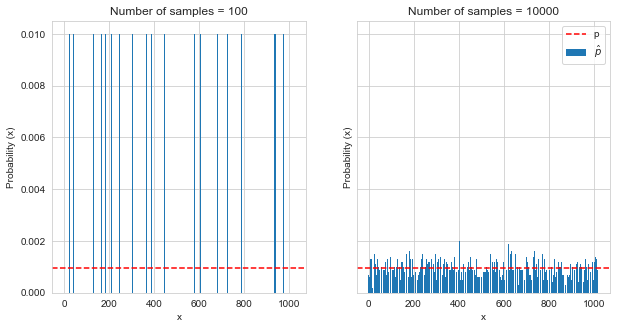

In [47]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
edges = np.arange(-0.5, N, 1)

for column, S in enumerate((100, 10000)):
    x = np.random.randint(0, N, int(S))
    phat = np.histogram(x,edges)[0]
    phat = phat / S
    ax[column].bar(edges[:-1], phat, edgecolor='none', label=r'$\hat{p}$')
    ax[column].axhline(1/N, color='red', linestyle='--', label='p')
    ax[column].set_title("Number of samples = {}".format(S))
    ax[column].set_xlabel("x")
    ax[column].set_ylabel("Probability (x)")

plt.legend()

We observe from above that as the number of samples increases, the observed probability distribution approaches the true uniform distribution. It can also be seen from the first panel that in case of lesser no. of samples, there is an overestimation of the observed probability values and a corresponding undrestimation for the unobserved values; much unlike the true distribution values! 

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [48]:
sampleSz = np.round(np.logspace(1,5,num=10))
nRuns = 30

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sampleSz),nRuns))
h_mm = np.zeros((len(sampleSz),nRuns))
h_jk = np.zeros((len(sampleSz),nRuns))
h_cae = np.zeros((len(sampleSz),nRuns))
h_jvhw = np.zeros((len(sampleSz),nRuns))

for i, S in enumerate(sampleSz):
    for j in np.arange(nRuns):
        x = np.random.randint(0, N, int(S))
        
        phat = np.histogram(x,edges)[0]
        phat = phat / S
        
        h_mle[i,j] = entropy_mle(phat)
        h_mm[i,j] = entropy_mm(phat, S)
        h_cae[i,j] = entropy_cae(phat, S)
        h_jk[i,j] = entropy_jk(x, edges)
        
        h_jvhw[i,j] = entropy_jvwh(x)
        


In [42]:
from unseen import unseen, make_fingers

sampleSz = np.round(np.logspace(3,5,num=10))
nRuns = 30

h_unseen = np.zeros((len(sampleSz),nRuns))

for i, S in enumerate(sampleSz):
    for j in np.arange(nRuns):
        x = np.random.randint(0, N, int(S))
        f = make_fingers(x)
        h_unseen[i,j] = unseen(f)
        

/Users/nsinghi/Documents/University of Tübingen/Neural Data Science/unseen.py:71: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  
/Users/nsinghi/Documents/University of Tübingen/Neural Data Science/unseen.py:71: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  
/Users/nsinghi/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=8.07994e-60): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/nsinghi/Documents/University of Tübingen/Neural Data Science/unseen.py:71: OptimizeWarning: Solving system with option 

In [ ]:
from unseen import unseen, make_fingers
f = make_fingers(x)
h, x = unseen(f)
estimatedEntropy = -1*np.sum(np.multiply([i*np.log2(i) if i !=0 else 0 for i in x], h))
print(estimatedEntropy)

Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

Text(0.5, 1.0, 'Comparison of entropy estimated using various estimators on \ndata sampled from uniform distribution')

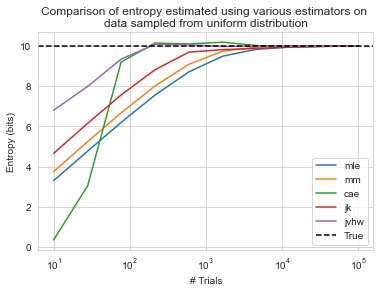

In [49]:
plt.semilogx(sampleSz,np.mean(h_mle, axis=1))

plt.semilogx(sampleSz,np.mean(h_mm, axis=1))
plt.semilogx(sampleSz, np.mean(h_cae, axis=1))
plt.semilogx(sampleSz,np.mean(h_jk, axis=1))
plt.semilogx(sampleSz,np.mean(h_jvhw, axis=1))
plt.axhline(H, color='black', linestyle='--')


plt.legend(['mle', 'mm',  'cae', 'jk', 'jvhw', 'True'])
plt.xlabel("# Trials")
plt.ylabel("Entropy (bits)")
plt.title("Comparison of entropy estimated using various estimators on \ndata sampled from uniform distribution")

### Zipf distribution

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (3 pts)

In [50]:
D = 10
N = 2**D

p = 1/(np.arange(0,N)+1)    # true distribution
p = p/np.sum(p)

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `random.choice` is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

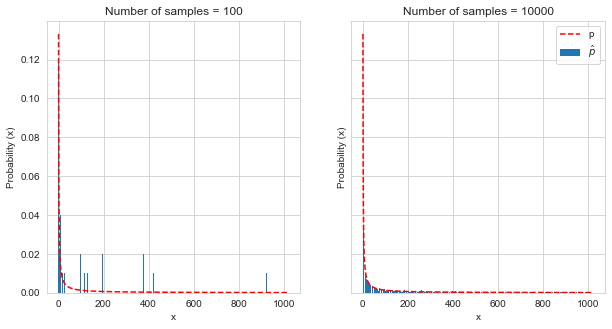

In [51]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
edges = np.arange(-0.5, N, 1)

for column, S in enumerate((100, 10000)):
    x = np.random.choice(np.arange(N), size=S, p=p)
    phat = np.histogram(x,edges)[0]
    phat = phat / S
    ax[column].bar(edges[:-1], phat, edgecolor='none', label=r'$\hat{p}$')
    ax[column].plot(np.arange(N), p, color='red', linestyle='--', label='p')
    ax[column].set_title("Number of samples = {}".format(S))
    ax[column].set_xlabel("x")
    ax[column].set_ylabel("Probability (x)")

plt.legend()

As seen in the case of uniform distribution, for 100 samples, the observed probability distribution is very different from the true distribution. For 10000 samples, the observed distribution is much closer to the true distribution.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [54]:
sampleSz = np.round(np.logspace(1,5,num=10))
nRuns = 30

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sampleSz),nRuns))
h_mm = np.zeros((len(sampleSz),nRuns))
h_jk = np.zeros((len(sampleSz),nRuns))
h_cae = np.zeros((len(sampleSz),nRuns))
h_jvhw = np.zeros((len(sampleSz),nRuns))

for i, S in enumerate(sampleSz):
    for j in np.arange(nRuns):
        
        x = np.random.choice(np.arange(N), size=int(S), p=p)
        
        phat = np.histogram(x,edges)[0]
        phat = phat / S
        
        h_mle[i,j] = entropy_mle(phat)
        h_mm[i,j] = entropy_mm(phat, S)
        h_cae[i,j] = entropy_cae(phat, S)
        h_jk[i,j] = entropy_jk(x, edges)
        
        h_jvhw[i,j] = entropy_jvwh(x)
        


Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

Text(0.5, 1.0, 'Comparison of entropy estimated using various estimators on \ndata sampled from Zipf distribution')

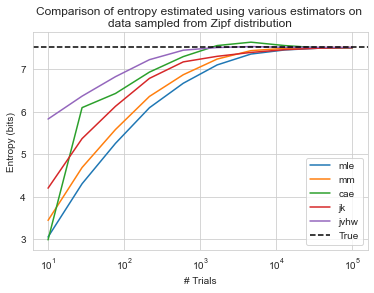

In [56]:
plt.semilogx(sampleSz,np.mean(h_mle, axis=1))

plt.semilogx(sampleSz,np.mean(h_mm, axis=1))
plt.semilogx(sampleSz, np.mean(h_cae, axis=1))
plt.semilogx(sampleSz,np.mean(h_jk, axis=1))
plt.semilogx(sampleSz,np.mean(h_jvhw, axis=1))
plt.axhline(H, color='black', linestyle='--')


plt.legend(['mle', 'mm',  'cae', 'jk', 'jvhw', 'True'])
plt.xlabel("# Trials")
plt.ylabel("Entropy (bits)")
plt.title("Comparison of entropy estimated using various estimators on \ndata sampled from Zipf distribution")

Since Zipf's distribution is skewed, we observe that both true and estimated values are smaller than those obtained in the case of uniform distribution (Entropy is highest for uniform distribution). Additionally, we find that the performance of estimators follows the order -- JVHW > JK > MM > MLE -- in both cases. The performance of CAE is slightly worse than the other estimators in the case of uniform distribution, which may be attributed to the high amount of variance of this estimator (despite lower bias).

In [59]:
from scipy.stats import poisson

poisson.pmf(1, 3)

0.14936120510359185

In [13]:
from unseen import unseen, make_fingers
f = make_fingers(x)
h, x = unseen(f)
estimatedEntropy = -1*np.sum(np.multiply([i*np.log2(i) if i !=0 else 0 for i in x], h))
print(estimatedEntropy)

ValueError: Phase 1 of the simplex method failed to find a feasible solution. The pseudo-objective function evaluates to 6.9e-04 which exceeds the required tolerance of 1e-09 for a solution to be considered 'close enough' to zero to be a basic solution. Consider increasing the tolerance to be greater than 6.9e-04. If this tolerance is unacceptably  large the problem may be infeasible.